<a href="https://colab.research.google.com/github/Ash100/Minor/blob/main/Analyzing_chain_Interactions_PDBs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ======================================================
# STEP 1: Install required libraries
# ======================================================
!pip install biopython mdtraj pandas matplotlib networkx nglview


Adjust Residue Number for each chain. Also Mention PDB path, and mention LXXLL motif

Found motif residues (chain,resid keys): {('B', (' ', 23, ' ')), ('B', (' ', 24, ' ')), ('B', (' ', 25, ' ')), ('B', (' ', 26, ' ')), ('B', (' ', 22, ' '))}
Saved all interactions -> motif_interactions_all_interactions.csv
Saved motif-only interactions -> motif_interactions_motif_interactions.csv (0 rows)


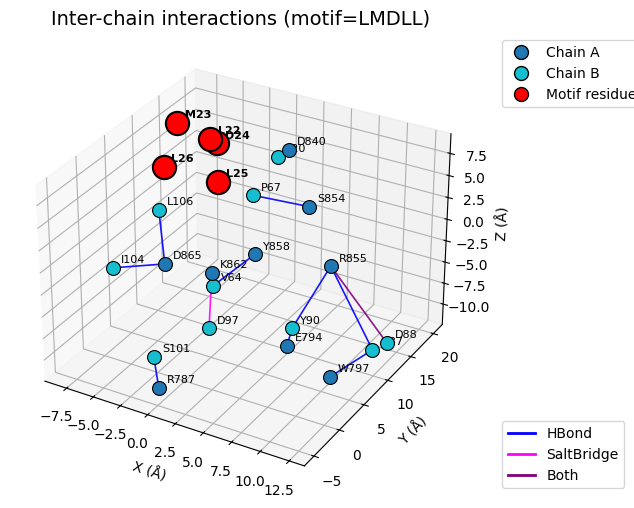

Saved polished figure -> motif_interactions_3D_motif_clean.png
Finished. Outputs:
 - All interactions CSV: motif_interactions_all_interactions.csv
 - Motif-only CSV: motif_interactions_motif_interactions.csv
 - 3D motif figure: motif_interactions_3D_motif_clean.png


In [17]:
# --------------------------
# Inter-chain HBonds & Salt-bridges, motif-aware + renumbering
# --------------------------
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import protein_letters_3to1

# --------------------------
# USER SETTINGS (edit these)
# --------------------------
PDB_FILE = "/content/NP_040193_1-116.pdb"            # <--- path to your PDB
OUTPUT_PREFIX = "motif_interactions"
MOTIF = "LMDLL"                    # pattern, use 'X' as wildcard
# Provide renumbering start for each chain (first residue in chain becomes this number)
CHAIN_STARTS = {"A": 669, "B": 1}   # <--- change to your chain IDs and starts
CONTACT_CUTOFF = 5.0                # Å: general contact threshold (used to find candidate pairs)
HBOND_CUTOFF = 3.5                  # Å: N/O - N/O for H-bond proxy
SALT_CUTOFF = 4.0                   # Å: N (pos) - O (neg) for salt-bridge

# Charged residue sets for salt-bridge detection
POSITIVE_RES = {"ARG", "LYS", "HIS"}
NEGATIVE_RES = {"ASP", "GLU"}

# --------------------------
# Helpers
# --------------------------
def atom_element(atom):
    """Return element symbol for a Biopython Atom (robust fallback)."""
    el = getattr(atom, "element", None)
    if el:
        return str(el).upper()
    name = atom.get_name()
    letters = [c for c in name if c.isalpha()]
    return letters[0].upper() if letters else ""

def three_to_one(resname):
    r = resname.upper()
    return protein_letters_3to1.get(r, "X")

# --------------------------
# Read structure & build sequences by chain
# --------------------------
if not os.path.exists(PDB_FILE):
    raise FileNotFoundError(f"PDB not found: {PDB_FILE}")

parser = PDBParser(QUIET=True)
structure = parser.get_structure("model", PDB_FILE)
model = structure[0]

# Build chain -> list of residue objects (standard residues only)
chain_reslist = {}
chain_seq = {}
for chain in model:
    cid = chain.get_id()
    reslist = []
    letters = []
    for res in chain:
        hetflag = res.get_id()[0]
        if hetflag.strip() != "":   # skip HETATM/waters
            continue
        reslist.append(res)
        letters.append(three_to_one(res.get_resname()))
    chain_reslist[cid] = reslist
    chain_seq[cid] = "".join(letters)

# Build renumber mapping: map (chain_id, res.get_id()) -> new sequential number
res_to_newnum = {}
for cid, reslist in chain_reslist.items():
    start = int(CHAIN_STARTS.get(cid, 1))
    for idx, res in enumerate(reslist):
        key = (cid, res.get_id())   # res.get_id() is (hetflag, resseq, icode) ensures unique
        res_to_newnum[key] = start + idx

# --------------------------
# Motif scanning (MOTIF uses 'X' as wildcard)
# --------------------------
motif = MOTIF.upper()
motif_len = len(motif)
motif_positions = set()   # store as (chain, res.get_id())

for cid, seq in chain_seq.items():
    if len(seq) < motif_len:
        continue
    for i in range(len(seq) - motif_len + 1):
        match = True
        for m_char, s_char in zip(motif, seq[i:i+motif_len]):
            if m_char == "X":
                continue
            if m_char != s_char:
                match = False
                break
        if match:
            # add all residues that belong to this motif instance
            for j in range(motif_len):
                res = chain_reslist[cid][i + j]
                motif_positions.add((cid, res.get_id()))

print(f"Found motif residues (chain,resid keys): {motif_positions}")

# --------------------------
# Compute inter-chain HBond proxies & salt-bridges (no hydrophobic)
# --------------------------
pairs = []   # list of dicts

chain_ids = list(chain_reslist.keys())
for i in range(len(chain_ids)):
    for j in range(i+1, len(chain_ids)):
        c1 = chain_ids[i]; c2 = chain_ids[j]
        for r1 in chain_reslist[c1]:
            for r2 in chain_reslist[c2]:
                # prepare atoms (skip hydrogens if present)
                atoms1 = [a for a in r1 if atom_element(a) != "H"]
                atoms2 = [a for a in r2 if atom_element(a) != "H"]
                if len(atoms1) == 0 or len(atoms2) == 0:
                    continue
                coords1 = np.array([a.get_coord() for a in atoms1])
                coords2 = np.array([a.get_coord() for a in atoms2])
                # pairwise distances
                d = np.sqrt(((coords1[:, None, :] - coords2[None, :, :])**2).sum(axis=2))
                min_dist = float(d.min())
                if min_dist > CONTACT_CUTOFF:
                    continue

                types = set()
                atom_examples = []

                # HBond proxy: any N/O - N/O <= HBOND_CUTOFF
                idxs = np.where(d <= HBOND_CUTOFF)
                for ia, ib in zip(*idxs):
                    a = atoms1[ia]; b = atoms2[ib]
                    if atom_element(a) in ("N","O") and atom_element(b) in ("N","O"):
                        types.add("HBond")
                        atom_examples.append((a.get_name(), b.get_name(), float(d[ia,ib])))

                # Salt-bridge: charged residue pair + N (from pos) - O (from neg) <= SALT_CUTOFF
                # check both directions
                r1name = r1.get_resname().strip()
                r2name = r2.get_resname().strip()
                if ((r1name in POSITIVE_RES and r2name in NEGATIVE_RES) or
                    (r2name in POSITIVE_RES and r1name in NEGATIVE_RES)):
                    idxs_s = np.where(d <= SALT_CUTOFF)
                    for ia, ib in zip(*idxs_s):
                        a = atoms1[ia]; b = atoms2[ib]
                        # require one atom be N and the other O
                        if (atom_element(a) == "N" and atom_element(b) == "O") or \
                           (atom_element(a) == "O" and atom_element(b) == "N"):
                            types.add("SaltBridge")
                            atom_examples.append((a.get_name(), b.get_name(), float(d[ia,ib])))

                # Only record if we found HBond or SaltBridge (we skip hydrophobic/other)
                if len(types) == 0:
                    continue

                key1 = (c1, r1.get_id()); key2 = (c2, r2.get_id())
                motif_involved = (key1 in motif_positions) or (key2 in motif_positions)

                pairs.append({
                    "chainA": c1,
                    "resA_3let": r1.get_resname().strip(),
                    "resA_key": r1.get_id(),
                    "resA_newnum": res_to_newnum.get(key1, None),
                    "resA_one": three_to_one(r1.get_resname()),
                    "chainB": c2,
                    "resB_3let": r2.get_resname().strip(),
                    "resB_key": r2.get_id(),
                    "resB_newnum": res_to_newnum.get(key2, None),
                    "resB_one": three_to_one(r2.get_resname()),
                    "min_dist": min_dist,
                    "types": ";".join(sorted(types)),
                    "atom_examples": atom_examples[:6],
                    "motif_involved": motif_involved
                })

# --------------------------
# Save CSVs
# --------------------------
if len(pairs) == 0:
    print("No inter-chain HBond or salt-bridge interactions found (within thresholds).")
else:
    df_all = pd.DataFrame(pairs)
    all_csv = f"{OUTPUT_PREFIX}_all_interactions.csv"
    df_all.to_csv(all_csv, index=False)
    print(f"Saved all interactions -> {all_csv}")

    df_motif = df_all[df_all["motif_involved"] == True]
    motif_csv = f"{OUTPUT_PREFIX}_motif_interactions.csv"
    df_motif.to_csv(motif_csv, index=False)
    print(f"Saved motif-only interactions -> {motif_csv} ({len(df_motif)} rows)")

# --------------------------
# 3D centroid figure (only residues involved in saved interactions + motif residues)
# --------------------------
# --------------------------
# 3D centroid figure (cleaned: motif color + legends + better labels)
# --------------------------
motif_color = 'red'   # dedicated color for motif residues

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plot centroids and labels
for key, centroid in centroid_map.items():
    cid, reskey = key
    res_obj = None
    for r in chain_reslist[cid]:
        if r.get_id() == reskey:
            res_obj = r; break
    if res_obj is None:
        continue
    newnum = res_to_newnum.get((cid, reskey), "?")
    one = three_to_one(res_obj.get_resname())
    label = f"{one}{newnum}"
    is_motif = (cid, reskey) in motif_positions

    if is_motif:
        col = motif_color
        size = 280
        edge = 'black'
        lw = 1.5
    else:
        col = chain_color_map.get(cid, (0.5,0.5,0.5))
        size = 100
        edge = 'k'
        lw = 0.8

    ax.scatter(centroid[0], centroid[1], centroid[2],
               s=size, color=col,
               edgecolors=edge, linewidths=lw,
               zorder=5 if is_motif else 3)

    # shift label a little bit for readability
    ax.text(centroid[0]+0.5, centroid[1]+0.5, centroid[2]+0.5,
            label, fontsize=8,
            weight='bold' if is_motif else 'normal')

# draw interaction lines
for row in pairs:
    kA = (row["chainA"], row["resA_key"])
    kB = (row["chainB"], row["resB_key"])
    if kA not in centroid_map or kB not in centroid_map:
        continue
    cA = centroid_map[kA]; cB = centroid_map[kB]
    if "HBond" in row["types"] and "SaltBridge" in row["types"]:
        base_color = 'purple'
        itype = "Both"
    elif "HBond" in row["types"]:
        base_color = 'blue'
        itype = "HBond"
    elif "SaltBridge" in row["types"]:
        base_color = 'magenta'
        itype = "SaltBridge"
    else:
        continue
    lw = 2.2 if row["motif_involved"] else 1.2
    ax.plot([cA[0], cB[0]], [cA[1], cB[1]], [cA[2], cB[2]],
            color=base_color, linewidth=lw, alpha=0.9,
            label=itype)

# legends
from matplotlib.lines import Line2D
# chain legend
chain_handles = [Line2D([0],[0], marker='o', color='w',
                        markerfacecolor=chain_color_map[c],
                        markeredgecolor='k', markersize=10,
                        label=f"Chain {c}")
                 for c in chain_list]
motif_handle = Line2D([0],[0], marker='o', color='w',
                      markerfacecolor=motif_color,
                      markeredgecolor='k', markersize=10,
                      label="Motif residues")
chain_handles.append(motif_handle)

# interaction legend
int_handles = [Line2D([0],[0], color='blue', lw=2, label="HBond"),
               Line2D([0],[0], color='magenta', lw=2, label="SaltBridge"),
               Line2D([0],[0], color='purple', lw=2, label="Both")]

leg1 = ax.legend(handles=chain_handles, loc='upper left', bbox_to_anchor=(1.05, 1.0))
ax.add_artist(leg1)
ax.legend(handles=int_handles, loc='lower left', bbox_to_anchor=(1.05, 0.0))

ax.set_xlabel("X (Å)"); ax.set_ylabel("Y (Å)"); ax.set_zlabel("Z (Å)")
plt.title(f"Inter-chain interactions (motif={MOTIF})", fontsize=14)
outfig = f"{OUTPUT_PREFIX}_3D_motif_clean.png"
plt.savefig(outfig, dpi=600, bbox_inches='tight')
plt.show()
print(f"Saved polished figure -> {outfig}")

# --------------------------
# Done
# --------------------------
print("Finished. Outputs:")
if len(pairs)>0:
    print(" - All interactions CSV:", all_csv)
    print(" - Motif-only CSV:", motif_csv)
print(" - 3D motif figure:", outfig)
